# Семинар 8. 
## Python применение статистических критериев на практике - пайплайн оценки A/B.

## Домашнее задание.
На сайте запущен А/В тест с целью увеличить доход.    
В приложенном excel файле вы найдете сырые данные по результатам эксперимента – user_id, тип выборки variant_name и доход принесенный пользователем revenue.   
Проанализируйте результаты эксперимента и напишите свои рекомендации менеджеру.

In [2]:
# Загрузим библиотеки
from typing import Union
from tqdm import tqdm

import pandas as pd
import numpy as np

from scipy import stats
from statsmodels.stats.meta_analysis import effectsize_smd
# from statsmodels.stats import proportion
from statsmodels.stats.power import tt_ind_solve_power
from statsmodels.stats.power import zt_ind_solve_power

Создадим датафрэйм по имеющимся данным:

In [3]:
df = pd.read_excel('data/gb_sem_8_hm.xlsx')

C:\Users\Human\anaconda3\lib\site-packages\openpyxl\worksheet\_read_only.py:79: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


Помотрим на содержимое датафрэйма

In [4]:
df.head(10)

,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0
5,2380,variant,0.0
6,2849,control,0.0
7,9168,control,0.0
8,6205,variant,0.0
9,7548,control,0.0


Выведем информацию о данных:

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7865 entries, 0 to 7864
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   USER_ID       7865 non-null   int64  
 1   VARIANT_NAME  7865 non-null   object 
 2   REVENUE       7865 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 184.5+ KB


Выведем описательную статистику по исходным данным:

In [23]:
df.describe()

,USER_ID,REVENUE
count,7865.000000,7865.000000
mean,4977.856707,0.126442
std,2890.696828,2.613860
min,2.000000,0.000000
25%,2463.000000,0.000000
50%,4965.000000,0.000000
75%,7504.000000,0.000000
max,10000.000000,196.010000


Выведем информацию о количестве пользователей в группах:

In [24]:
df.VARIANT_NAME.value_counts()

variant    3934
control    3931
Name: VARIANT_NAME, dtype: int64

Проверим, сколько пользователей являются уникальными:

In [25]:
df.USER_ID.nunique()

6324

*Из 10000 записей уникальными являются 6324 пользователя*

Сгруппируем пользователей по ID и группе:

In [26]:
df = df.groupby(['USER_ID', 'VARIANT_NAME'], as_index=False).agg({'REVENUE': 'sum'})
df.shape

(7865, 3)

*Из 6324 уникальных пользователей некоторые присутствуют в двух группах*

Сгруппируем пользователей по вхождению в группы:

In [27]:
df.groupby('USER_ID', as_index=False).agg({'VARIANT_NAME': 'count'})['VARIANT_NAME'].value_counts()

1    4783
2    1541
Name: VARIANT_NAME, dtype: int64

*Из 6324 уникальных пользователей 1541 входят в две группы.   
Таких пользователей нужно удалить из датафрэйма.*

In [28]:
# Создадим переменную, собирающую ID, которые входят в состав только одной группы

unique_ids = \
(df
 .groupby('USER_ID', as_index=False)
 .agg({'VARIANT_NAME': 'count'})
 #.['VARIANT_NAME'].value_counts()
 .query('VARIANT_NAME == 1')
 .USER_ID
 .values
 )

In [29]:
# Создадим новый датафрэйм, содержащий только уникальные ID используя переменную, соданную выше
df_new = df[df.USER_ID.isin(unique_ids)].copy(deep=True)

In [30]:
df_new

,USER_ID,VARIANT_NAME,REVENUE
0,2,control,0.0
3,4,variant,0.0
4,5,variant,0.0
5,6,variant,0.0
6,9,variant,0.0
...,...,...,...
7856,9990,variant,0.0
7857,9992,control,0.0
7858,9993,control,0.0
7859,9995,variant,0.0


*Новый датафрэйм содержит всего 4783 уникальных пользователя*

Посмотрим описательную статистику для нового датафрэйма

In [31]:
df_new.describe()

,USER_ID,REVENUE
count,4783.000000,4783.000000
mean,4994.395777,0.135873
std,2898.618472,3.011392
min,2.000000,0.000000
25%,2476.000000,0.000000
50%,4975.000000,0.000000
75%,7515.000000,0.000000
max,9998.000000,196.010000


Создадим две датафрэйма для контрольной и тестовой групп:

In [32]:
control = df_new.query('VARIANT_NAME == "control"')

test = df_new.query('VARIANT_NAME == "variant"')

In [33]:
len(control), len(test)

(2390, 2393)

*Размер групп практически равный*

Проверим данные на нормальность:

In [34]:
from scipy.stats import shapiro

In [35]:
alpha = 0.05

st = shapiro(df_new.REVENUE)
print('Distribution is {}normal\n'.format( {True:'not ',
False:''}[st[1] < alpha]));

Distribution is not normal



Визуализируем распределение: 

In [37]:
import matplotlib.pyplot as plt

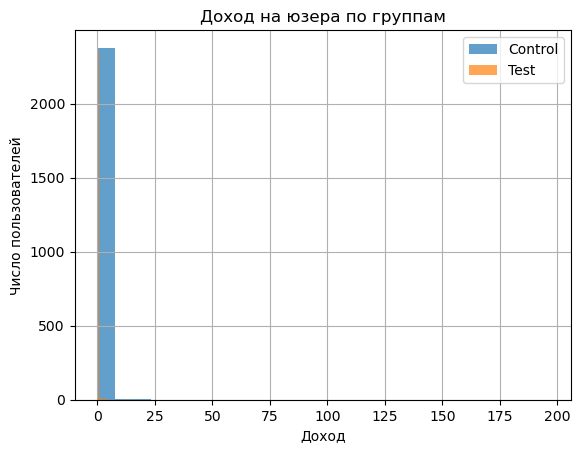

In [38]:
control.REVENUE.hist(bins = 25, alpha =0.7, label='Control')
test.REVENUE.hist(bins = 25, alpha =0.7, label='Test')
plt.title('Доход на юзера по группам')
plt.xlabel('Доход')
plt.ylabel('Число пользователей')
plt.legend();

**Распределение не нормальное**    
Применим притерий Манна-Уитни

In [40]:
from scipy.stats import mannwhitneyu

In [42]:
wm_stats = mannwhitneyu(x=control.REVENUE.values,
                       y=test.REVENUE.values)
wm_stats

MannwhitneyuResult(statistic=2874161.0, pvalue=0.2104875008271777)

*Проверка по критерию Манна-Уитни показывает отсутстве статистически значимых различий между выборками.*

Найдем значения effect_size, альфа, бета, мощности эксперимента,доверительного интервала и разницы средних:

In [51]:
# Функция для расчёта непрерывной метрики
def continious_result(control: pd.DataFrame,   # подаём дата фрэймы
                      treatment: pd.DataFrame,
                      column: str,             # подаём название строки, по которой будем рассчитывать
                      n_iters: int = 10_000) -> pd.DataFrame:
    # Статистика по выборкам
    size = control.loc[:, column].shape[0]    # выбираем размер - количество наблюдений
    
    control_mean = control.loc[:, column].mean()   # считаем среднее значение
    treatment_mean = treatment.loc[:, column].mean()
    
    control_std = control.loc[:, column].std(ddof=1)   # считаем стандартное отклонение
    treatment_std = treatment.loc[:, column].std(ddof=1)
    
    # Бутсрап
    booted_diff = []
    for _ in tqdm(range(n_iters)):
        control_sample = control.loc[:, column].sample(n=size, replace=True).values
        treatment_sample = treatment.loc[:, column].sample(n=size, replace=True).values
        booted_diff.append(np.mean(control_sample - treatment_sample))
    
    # Считаем статистику после бустрапа
    md_ci, std_ci = np.mean(booted_diff), np.std(booted_diff, ddof=1)
    left_ci, right_ci = np.percentile(booted_diff, [2.5, 97.5])
    p_value_ci = 2 * (1 - stats.norm.cdf(np.abs(md_ci / std_ci)))
    
    # Считаем мощность эксперимента
    effect_size, _ = effectsize_smd(mean1=treatment_mean, sd1=treatment_std, nobs1=size,
                                    mean2=control_mean, sd2=control_std, nobs2=size)
    power = tt_ind_solve_power(effect_size=effect_size,
                               nobs1=size,
                               alpha=.05,
                               power=None,
                               ratio=1)
    # Формируем отчёт 
    result = pd.DataFrame({'effect_size': effect_size,
                           'alpha': p_value_ci, 
                           'beta': (1-power),
                           'power': power,
                           'CI': f'[{np.round(left_ci, 3)}, {np.round(right_ci, 3)}]',
                           'difference': md_ci,},
                          index=[column]) 
    return result

In [52]:
continious_result(control, test, column='REVENUE')

100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:05<00:00, 1666.86it/s]


,effect_size,alpha,beta,power,CI,difference
REVENUE,-0.040483,0.159383,0.712143,0.287857,"[-0.004, 0.32]",0.122265


In [53]:
import plotly.express as px
fig = px.histogram(df_new, x="REVENUE",
                   color='VARIANT_NAME', barmode='group',
                   height=400)
fig.show()

***Вывод:    
Сатистически значимых различий между двумя группами эксперимента не выявлено.    
Пользователи почти ничего не покупают.   
Мощность эксперимента маленькая.   
Эксперимент необходимо остановить и проверить дизайн.***